# Load data

In [36]:
import pandas as pd
import numpy as np
from utils.currency_dataframe import CurrencyDataframe
from utils.oil_dataframe import OilDataFrame
from utils.ptax_dataframe import PTaxlDataFrame
from utils.boi_dataframe import BoiDataFrame
from utils.soja_dataframe import SojaDataFrame
from utils.bovespa_dataframe import BovespaDataFrame

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from importlib import reload 

import matplotlib.pyplot as plt

csvFile = r'..\data\global_inflation_data.csv'
#currencyDf = CurrencyDataframe(csvFile).get_dataframe()

csvFile = r'..\data\historico_ptax.csv'
#ptaxDf = PTaxlDataFrame(csvFile).get_dataframe()

csvFile = r'..\data\crude-oil-prices.csv'
#oilDf = OilDataFrame(csvFile).get_dataframe()

xlsFile = r'..\data\cepea-consulta-boi.xls'
#boiDf = BoiDataFrame(xlsFile).get_dataframe()

xlsFile = r'..\data\cepea-consulta-soja.xls'
#sojaDf = SojaDataFrame(xlsFile).get_dataframe()

b3File = r'..\data\COTAHIST_A2012.TXT'
b3DF = BovespaDataFrame(b3File).get_dataframe()
#b3DF.head()

# Model based on PETR4 stock

## PETR4 dataframe

### Creating dataframe

In [37]:
df_petro = b3DF[ b3DF['sigla_acao'] == 'PETR4']
#ajustar o index
df_petro = df_petro.set_index(pd.DatetimeIndex(df_petro['data_pregao'].values))
#retirar a coluna usada para o index
df_petro.drop(['data_pregao', 'sigla_acao', 'nome_acao', 'qtd', 'vol'], inplace=True, axis=1)
df_petro.head()

,fechamento
2012-01-02,21.73
2012-01-03,22.41
2012-01-04,22.57
2012-01-05,22.31
2012-01-06,22.33


### Data visualization

Text(0.5, 0, 'data')

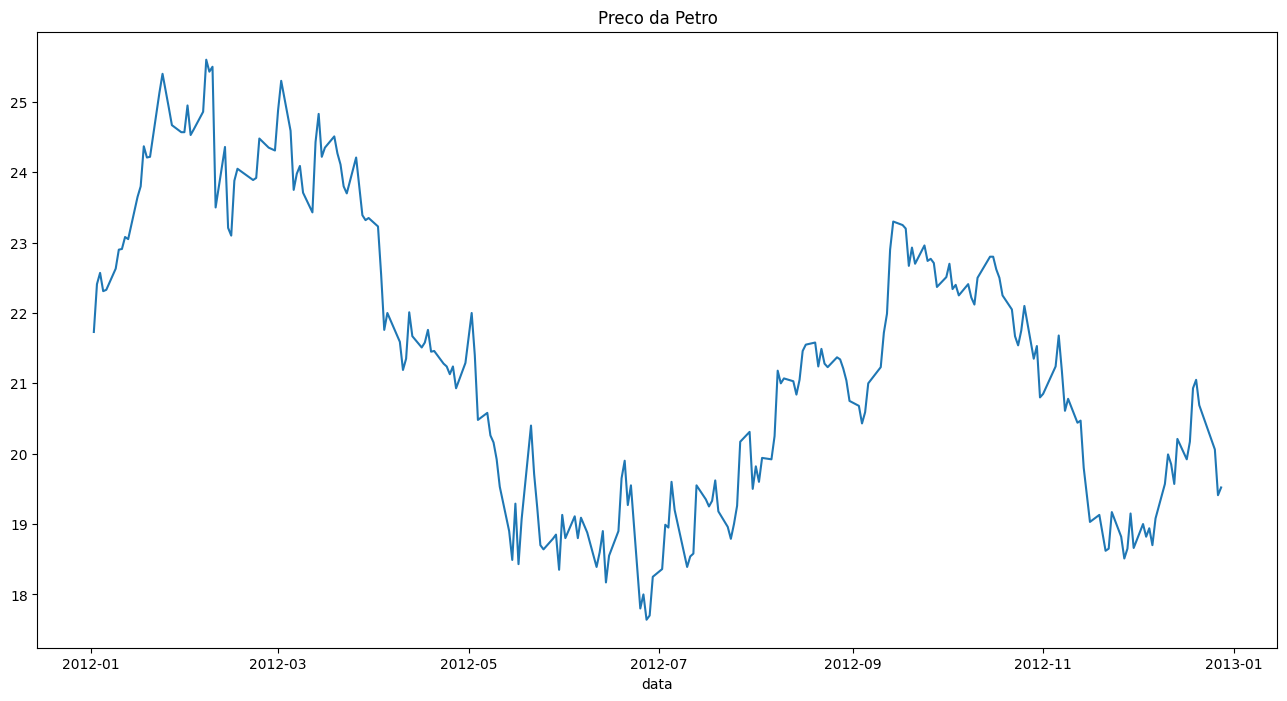

In [38]:
plt.figure(figsize=(16, 8))
plt.title('Preco da Petro')
plt.plot(df_petro['fechamento'])
plt.xlabel('data')

In [39]:
qtd_linhas = len(df_petro)
qtd_linhas_treino = round(.70 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info = {
    f"linhas treino = 0:{qtd_linhas_treino}"
    f" linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste}"
}
info


{'linhas treino = 0:172 linhas teste = 172:246'}

In [40]:
#normalizando os dados
scaler = StandardScaler()
df_scaler = scaler.fit_transform(df_petro)

In [41]:
#separa em treino e teste
train = df_scaler[:qtd_linhas_treino]
test = df_scaler[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste]
print(len(train), len(test))


172 74


In [42]:
# convert an array of values into a df matrix
def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i + steps, 0])
    return np.array(dataX), np.array(dataY)

In [43]:
#gerenciando dados de treino e teste
steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(156, 15)
(156,)
(58, 15)
(58,)


In [44]:
#gerando os dados que o modelo espera
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [45]:
#Montando a rede
model = Sequential()
model.add(Input(shape=(steps, 1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 15, 35)         │         5,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 15, 35)         │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 35)             │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,096 (98.03 KB)

 Trainable params: 25,096 (98.03 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
#Treinamento do Modello
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
11/11 - 6s - 519ms/step - loss: 0.8927 - val_loss: 0.2503
Epoch 2/100
11/11 - 0s - 15ms/step - loss: 0.3031 - val_loss: 0.3184
Epoch 3/100
11/11 - 0s - 16ms/step - loss: 0.2548 - val_loss: 0.1822
Epoch 4/100
11/11 - 0s - 15ms/step - loss: 0.2397 - val_loss: 0.2033
Epoch 5/100
11/11 - 0s - 14ms/step - loss: 0.2150 - val_loss: 0.1783
Epoch 6/100
11/11 - 0s - 17ms/step - loss: 0.2249 - val_loss: 0.1584
Epoch 7/100
11/11 - 0s - 14ms/step - loss: 0.2375 - val_loss: 0.1607
Epoch 8/100
11/11 - 0s - 17ms/step - loss: 0.1964 - val_loss: 0.1469
Epoch 9/100
11/11 - 0s - 14ms/step - loss: 0.1922 - val_loss: 0.1370
Epoch 10/100
11/11 - 0s - 14ms/step - loss: 0.1808 - val_loss: 0.1302
Epoch 11/100
11/11 - 0s - 15ms/step - loss: 0.1647 - val_loss: 0.1369
Epoch 12/100
11/11 - 0s - 15ms/step - loss: 0.1754 - val_loss: 0.1228
Epoch 13/100
11/11 - 0s - 19ms/step - loss: 0.1611 - val_loss: 0.1240
Epoch 14/100
11/11 - 0s - 14ms/step - loss: 0.1535 - val_loss: 0.1134
Epoch 15/100
11/11 - 0s - 15

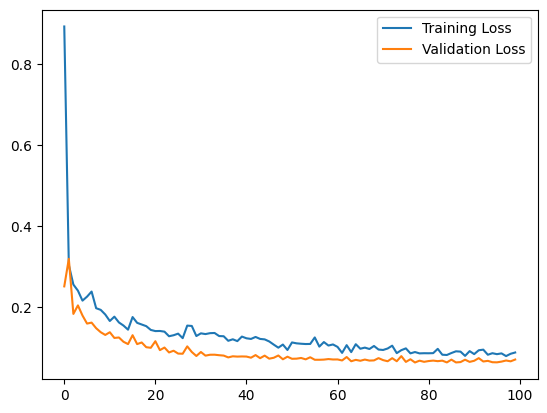

In [47]:
plt.plot(validation.history['loss'], label='Training Loss')
plt.plot(validation.history['val_loss'], label='Validation Loss')
plt.legend()

In [50]:
#Fazendo a previsão
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[22.669882],
       [22.580963],
       [22.643732],
       [22.590563],
       [22.524931],
       [22.416868],
       [22.395445],
       [22.33972 ],
       [22.24794 ],
       [22.316309],
       [22.571041],
       [22.822458],
       [22.896889],
       [22.805285],
       [22.573853],
       [22.291327],
       [21.93715 ],
       [21.617712],
       [21.467659],
       [21.547592],
       [21.497326],
       [21.429909],
       [21.172913],
       [20.898752],
       [20.754951],
       [20.813852],
       [20.8858  ],
       [20.805958],
       [20.677078],
       [20.49324 ],
       [20.316973],
       [20.094177],
       [19.80985 ],
       [19.545525],
       [19.31194 ],
       [19.125729],
       [18.99782 ],
       [18.90974 ],
       [18.84962 ],
       [18.812864],
       [18.805407],
       [18.808855],
       [18.823353],
       [18.852335],
       [18.886875],
       [18.923527],
       [18.954548],
       [18.995348],
       [19.090755],
       [19.22077 ],


In [56]:
#previsao para os proximos 10 dias
length_test = len(test)
days_input_steps = length_test - steps 
#transforma em array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
#transformar em lista
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()


[-1.2968220016410186,
 -1.1100259205392866,
 -0.8691572896449464,
 -0.6626984631640852,
 -0.7315180719910378,
 -0.8691572896449464,
 -0.5545533635788705,
 -0.6971082675775606,
 -0.5742161089579998,
 -0.20062394675453596,
 -0.14163571061714628,
 -0.3186004190293136,
 -0.628288658750608,
 -0.9478082711614655,
 -0.8937357213688589]

In [59]:
#loop para prever os proximos 10 dias
pred_output = []
i = 0
n_future = 10
while (i < n_future):

    if(len(list_output_steps) > steps):
        input_steps = np.array(list_output_steps[1:])
        print(f"{i} dia. Valores de entrada -> {input_steps}")
        input_steps = input_steps.reshape(1, -1)
        input_steps = input_steps.reshape(( 1, steps, 1))
        pred = model.predict(input_steps, verbose = 0)
        print(f"{i} dia. Valor Previsto -> {pred}")
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        pred_output.extend(pred.tolist())
        i += 1
    else:
        input_steps = input_steps.reshape((1, steps, 1))
        pred = model.predict(input_steps, verbose=0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output.extend(pred.tolist())
        i += 1
print(pred_output)

0 dia. Valores de entrada -> [-0.86915729 -0.66269846 -0.73151807 -0.86915729 -0.55455336 -0.69710827
 -0.57421611 -0.20062395 -0.14163571 -0.31860042 -0.62828866 -0.94780827
 -0.89373572 -0.4411768  -0.58333039]
0 dia. Valor Previsto -> [[-0.66771626]]
1 dia. Valores de entrada -> [-0.66269846 -0.73151807 -0.86915729 -0.55455336 -0.69710827 -0.57421611
 -0.20062395 -0.14163571 -0.31860042 -0.62828866 -0.94780827 -0.89373572
 -0.4411768  -0.58333039 -0.66771626]
1 dia. Valor Previsto -> [[-0.7190397]]
2 dia. Valores de entrada -> [-0.73151807 -0.86915729 -0.55455336 -0.69710827 -0.57421611 -0.20062395
 -0.14163571 -0.31860042 -0.62828866 -0.94780827 -0.89373572 -0.4411768
 -0.58333039 -0.66771626 -0.71903968]
2 dia. Valor Previsto -> [[-0.75463104]]
3 dia. Valores de entrada -> [-0.86915729 -0.55455336 -0.69710827 -0.57421611 -0.20062395 -0.14163571
 -0.31860042 -0.62828866 -0.94780827 -0.89373572 -0.4411768  -0.58333039
 -0.66771626 -0.71903968 -0.75463104]
3 dia. Valor Previsto -> [[

In [63]:
#Transforma a saida
prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = prev[0].tolist()
list_output_prev

[19.97979226661609,
 19.87538484464265,
 19.80298119353371,
 19.735108317987866,
 19.671564693919425,
 19.633285302971334,
 19.594623962041343,
 19.5698532325484,
 19.558991545094813,
 19.548422322198793]

In [65]:
df_petro = b3DF[ b3DF['sigla_acao'] == 'PETR4']
df_petro = df_petro.set_index(pd.DatetimeIndex(df_petro['data_pregao'].values))

dates = pd.to_datetime(df_petro['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10, freq='b')
predict_dates

DatetimeIndex(['2012-12-31', '2013-01-01', '2013-01-02', '2013-01-03',
               '2013-01-04', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11'],
              dtype='datetime64[ns]', freq='B')

In [66]:
#cria o dataframe de previsao

forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'data_pregao': np.array(forecast_dates), 'preco_fechamento': list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])
df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
df_forecast.drop('data_pregao', axis = 1, inplace=True )
df_forecast

,preco_fechamento
2012-12-31,19.979792
2013-01-01,19.875385
2013-01-02,19.802981
2013-01-03,19.735108
2013-01-04,19.671565
2013-01-07,19.633285
2013-01-08,19.594624
2013-01-09,19.569853
2013-01-10,19.558992
2013-01-11,19.548422


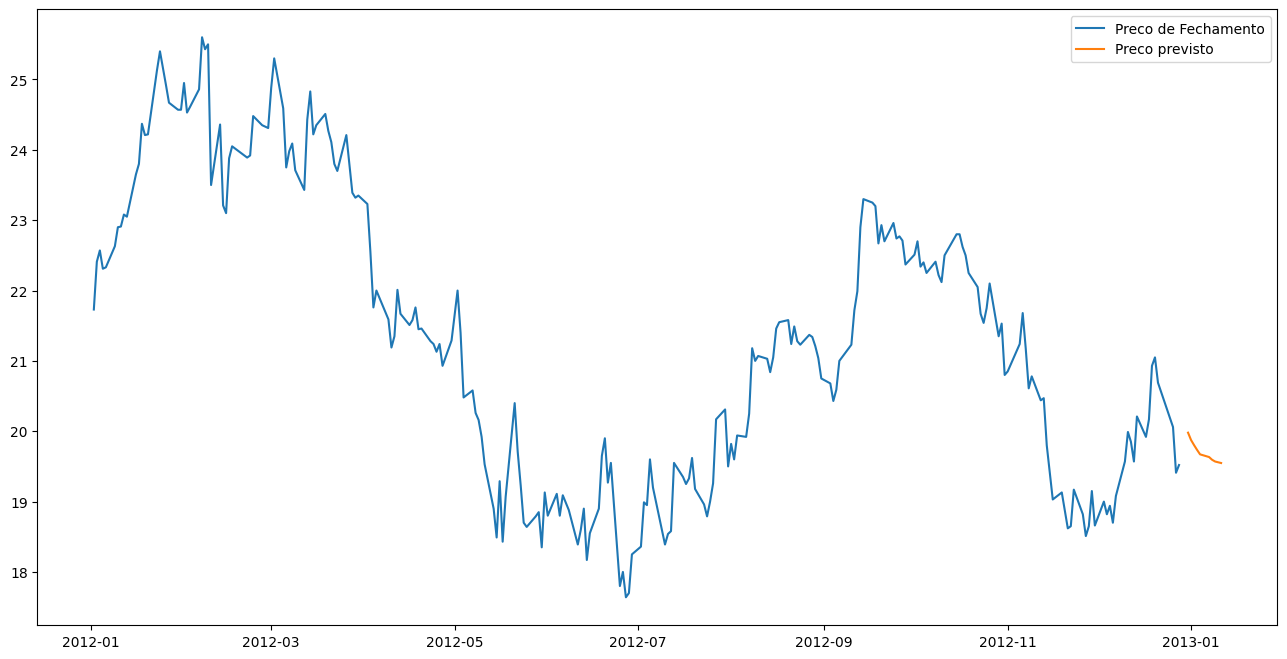

In [68]:
#plotar o gráfico
plt.figure(figsize=(16,8))
plt.plot(df_petro['fechamento'])
plt.plot(df_forecast['preco_fechamento'])
plt.legend(['Preco de Fechamento', 'Preco previsto'])
plt.show()

### Linear Regression Model

#### Output model

In [49]:
import joblib

joblib.dump(model, './output/modelLinearBrazil.pkl')

['./output/modelLinearBrazil.pkl']

# Running Streamlit

streamlit run streamlit/app.py